In [1]:
import torch
import MiniFL as mfl
import numpy as np

In [2]:
STEPS = 2000
SIZE = 100

NOISE_LAMBDAS = list(np.linspace(0, 1, 3))
NUM_CLIENTS = (10, 20, 50, 100)

In [3]:
TOPK_GAMMAS = {
    10:  {0.0: 32, 0.5: 64,  1.0: 128},
    20:  {0.0: 32, 0.5: 128, 1.0: 128},
    50:  {0.0: 64, 0.5: 128, 1.0: 128},
    100: {0.0: 64, 0.5: 128, 1.0: 128},
}

EDEN_GAMMAS = {
    10:  {0.0: 8, 0.5: 8, 1.0: 8},
    20:  {0.0: 8, 0.5: 8, 1.0: 8},
    50:  {0.0: 8, 0.5: 8, 1.0: 8},
    100: {0.0: 8, 0.5: 8, 1.0: 8},
}

MARINA_EDEN_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}
PERMK_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}
EF21_EDEN_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}
TOPK_METRICS = {num_clients: {} for num_clients in NUM_CLIENTS}

In [4]:
def measure_all(seed, num_clients, noise_lambda, steps=STEPS):
    def get_task(seed):
        return mfl.tasks.create_worst_case_tridiagonal_quadratics(
            num_clients=num_clients,
            size=SIZE,
            noise_lambda=noise_lambda,
            seed=seed,
        )

    master, clients = mfl.algorithms.get_marina_master_and_clients(
        get_task(seed),
        compressors=[mfl.compressors.EdenUnbiasedCompressor(SIZE, bits=1, seed=1 + 7*seed + i) for i in range(num_clients)],
        p=1/num_clients,
        gamma_multiplier=1,
        seed=1 + 13 * seed,
    )
    marina_eden_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    master, clients = mfl.algorithms.get_permk_marina_master_and_clients(
        get_task(seed+1),
        p=1/num_clients,
        gamma_multiplier=1,
        seed=7 + 5 * seed,
    )
    permk_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, int(steps * max(1, num_clients/70)))

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        get_task(seed),
        compressors=[mfl.compressors.EdenContractiveCompressor(SIZE, bits=1, seed=1 + 7*seed + i) for i in range(num_clients)],
        gamma_multiplier=EDEN_GAMMAS[num_clients][noise_lambda],
    )
    ef21_eden_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, steps)

    master, clients = mfl.algorithms.get_ef21_master_and_clients(
        get_task(seed),
        compressors=[mfl.compressors.TopKCompressor(SIZE, k=1) for _ in range(num_clients)],
        gamma_multiplier=TOPK_GAMMAS[num_clients][noise_lambda],
    )
    topk_metrics = mfl.algorithms.run_algorithm_sequantially(master, clients, int(steps * SIZE / 32))

    return marina_eden_metrics, permk_metrics, ef21_eden_metrics, topk_metrics

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot():
    fig, axes = plt.subplots(len(NUM_CLIENTS), len(NOISE_LAMBDAS), figsize=(16, 20))

    for i, num_clients in enumerate(NUM_CLIENTS):
        for j, noise_lambda in enumerate(NOISE_LAMBDAS):
            ax = axes[i][j]
            ax.set_title(r"$L_{\pm}=$" + str(noise_lambda) + ", " + f"{num_clients=}")

            try:
                ax.plot([metrics.total_bits_received/num_clients for metrics in MARINA_EDEN_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in MARINA_EDEN_METRICS[num_clients][noise_lambda]], color="green", label="MARINA EDEN")
                ax.plot([metrics.total_bits_received/num_clients for metrics in PERMK_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in PERMK_METRICS[num_clients][noise_lambda]], color="red", label="PermK")
                ax.plot([metrics.total_bits_received/num_clients for metrics in EF21_EDEN_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in EF21_EDEN_METRICS[num_clients][noise_lambda]], color="green", label="EF21 EDEN", linestyle="--")
                ax.plot([metrics.total_bits_received/num_clients for metrics in TOPK_METRICS[num_clients][noise_lambda]], [metrics.grad_norm**2 for metrics in TOPK_METRICS[num_clients][noise_lambda]], color="red", label="Top1", linestyle="--")
            except KeyError:
                pass

            ax.set_yscale("log")
            # ax.set_xlim(0, 1.5*1e6)
            ax.set_ylim(top=0.1)
            ax.set_xlabel("bits/n")
            ax.set_ylabel(r"$\|\nabla f(x)\|_2^2$")
            ax.legend()
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


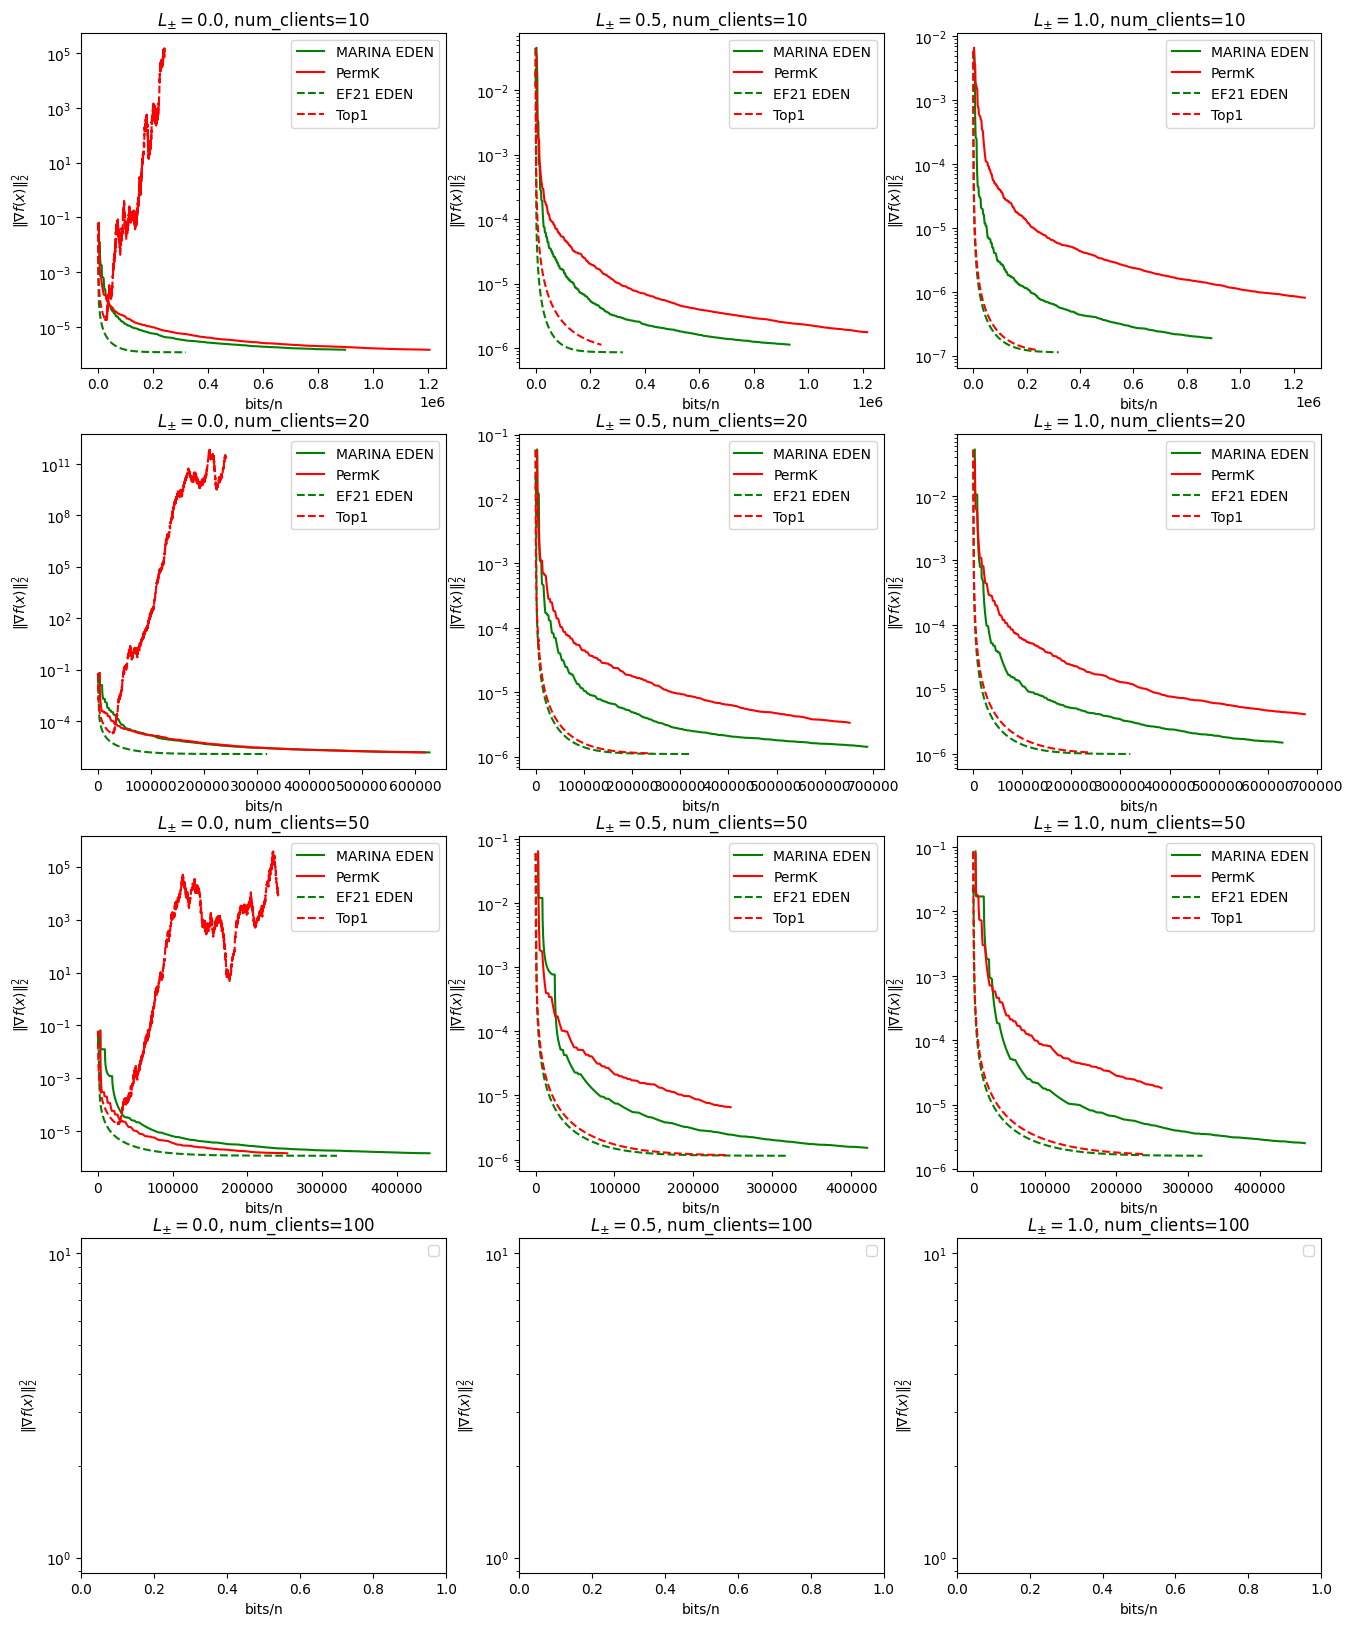

Measuring num_clients=100 noise_lambda=0.0


 17%|█▋        | 1081/6250 [01:21<06:13, 13.83it/s]

In [6]:
from IPython.display import clear_output

for i, num_clients in enumerate(NUM_CLIENTS):
    for j, noise_lambda in enumerate(NOISE_LAMBDAS):
        print(f"Measuring {num_clients=} {noise_lambda=}")
        marina_eden_metrics, permk_metrics, ef21_eden_metrics, topk_metrics = measure_all(seed=101*i + j, num_clients=num_clients, noise_lambda=noise_lambda)
        MARINA_EDEN_METRICS[num_clients][noise_lambda] = marina_eden_metrics
        PERMK_METRICS[num_clients][noise_lambda] = permk_metrics
        EF21_EDEN_METRICS[num_clients][noise_lambda] = ef21_eden_metrics
        TOPK_METRICS[num_clients][noise_lambda] = topk_metrics
        clear_output(wait=True)
        plot()
        plt.show()
